In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-pfruf30e
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-pfruf30e
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=122fd5d7591c8120d165b66774c7b964a14c72a5e5f2462be0a15d5948c234f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-ttq6kqsj/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
import cv2
import numpy as np
import random
import glob
import os
import imghdr
import itertools
import math
import json
from PIL import Image

import matplotlib.pyplot as plt
from keras.preprocessing.image import (ImageDataGenerator, array_to_img, img_to_array, load_img)
from keras.utils import generic_utils

import PIL
import keras
import keras.backend as K

from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense, Flatten, Dropout, Activation, LeakyReLU, Reshape, Concatenate, Input
from keras.layers import Conv2D, UpSampling2D, Conv2DTranspose, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras import optimizers, losses
from copy import deepcopy

try:
    from keras_contrib.layers.normalization import InstanceNormalization
except Exception:
    from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

from IPython.display import display, Image, Markdown, SVG
from keras.utils.vis_utils import model_to_dot

# Creating the Model

In [0]:
# Saving Models and global parameters
TIME_INTERVAL = 1
SHOW_SUMMARY = True

IMAGE_SZ = 128
INPUT_SHAPE = (IMAGE_SZ, IMAGE_SZ, 3)
EPOCHS = 5
BATCH_SIZE = 1

MASK_PERCENTAGE = 0.25 # for a 128x128 image it will be 32 pixels on both sides i.e., left and right so the unmasked image will be 128x64 --> center portion if I understood correctly

CHECKPOINT = '/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/model/'
SAVED_IMAGES = '/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/saved images'

## Discriminator (Local + Global)

In [0]:
def discriminator_block(layer_input, filters, kernel_size = 5, strides = 2, padding = 'same', activation='leakyrelu', dropout_rate=0.25, norm=True):
    conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(layer_input)
    if activation == 'leakyrelu':
        conv = LeakyReLU(alpha=0.2)(conv)
    if dropout_rate:
        conv = Dropout(rate=dropout_rate)(conv)
    if norm:
        conv = InstanceNormalization()(conv)
    return conv

def local_build_discriminator(local_disc_input):
    # disc_input = Input(shape = (IMAGE_SZ, IMAGE_SZ//2, 3)) # only center part
    model = discriminator_block(local_disc_input, 32, 5, norm=False)
    model = discriminator_block(model, 64, 5, 2)
    model = discriminator_block(model, 64, 5, 2)
    model = discriminator_block(model, 64, 5, 2)

    model = Flatten()(model)
    local_FC = Dense(512, activation='relu')(model)
    # output = Dense(1, activation='sigmoid')(FC)

    return local_FC

def global_build_discriminator(global_disc_input):
    # disc_input = Input(shape = (IMAGE_SZ, IMAGE_SZ, 3))
    model = discriminator_block(global_disc_input, 32, 5, norm=False)
    model = discriminator_block(model, 64, 5, 2)
    model = discriminator_block(model, 64, 5, 2)
    model = discriminator_block(model, 64, 5, 2)
    model = discriminator_block(model, 64, 5, 2)

    model = Flatten()(model)
    global_FC = Dense(512, activation='relu')(model)

    return global_FC

In [0]:
def build_discriminator():
    discriminator_input = Input(shape=(IMAGE_SZ, IMAGE_SZ, 3))

    local_discriminator_left = local_build_discriminator(keras.layers.Lambda(lambda x: x[:, :, :IMAGE_SZ//2, :])(discriminator_input))
    local_discriminator_right = local_build_discriminator(keras.layers.Lambda(lambda x: x[:, :, -IMAGE_SZ//2:, :])(discriminator_input))

    global_discriminator = global_build_discriminator(discriminator_input)

    concatenator = Concatenate()([global_discriminator, local_discriminator_left, local_discriminator_right])
    discriminator_output = Dense(1, activation='sigmoid')(concatenator)

    return Model(discriminator_input, discriminator_output)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 64, 64, 32)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 64, 64, 32)   0           leaky_

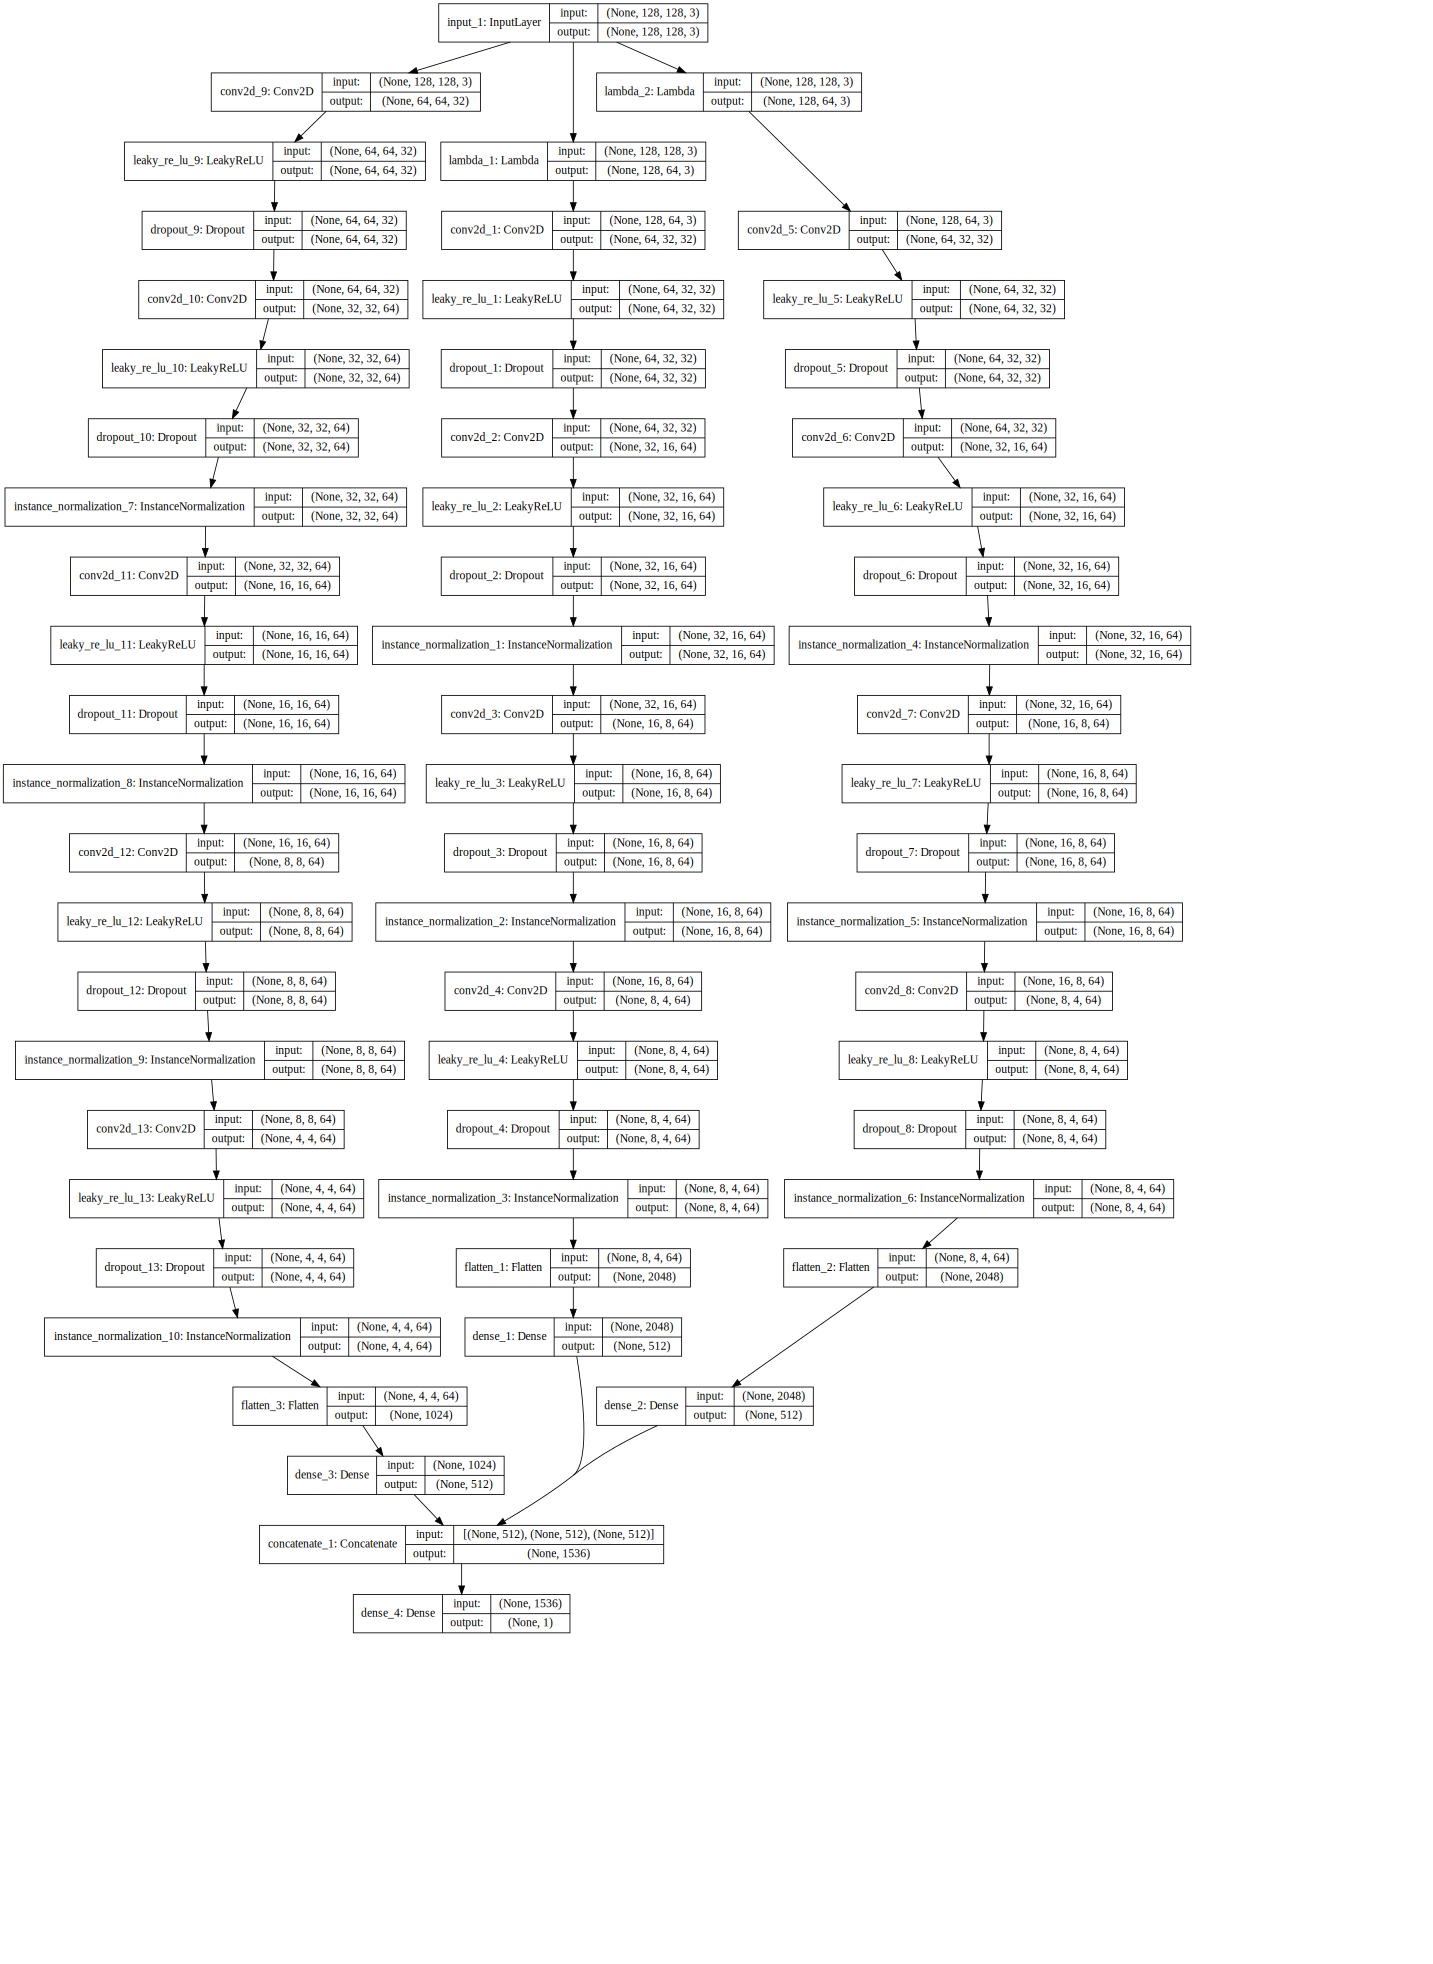

In [9]:
# local discriminator initialization
discriminator = build_discriminator()
discriminator.trainable = False
discriminator.compile(loss = losses.MSE, optimizer = optimizers.Adam(lr=0.0001, beta_1=0.5))
discriminator.summary()

# # Saving the Summary and Architecture
# with open('./drive/My Drive/Colab Notebooks/aml_proj3/inception_resnetv2/model/discriminator_summary.txt', 'w') as f:
#     with redirect_stdout(f):
#         discriminator.summary()
# plot_model(discriminator, to_file='./drive/My Drive/Colab Notebooks/aml_proj3/inception_resnetv2/model/discriminator_model.png')
SVG(model_to_dot(discriminator, show_layer_names=True, show_shapes=True, dpi=60).create(prog='dot', format='svg'))

## Generator

In [0]:
def generator_conv_block(layer_input, filters, kernel_size, strides, padding='same', activation='relu', norm=True, dilation_rate=1):
    conv = Conv2D(filters, kernel_size=kernel_size, strides=strides, dilation_rate=(dilation_rate, dilation_rate), padding=padding)(layer_input)
    if activation=='relu':
        conv = Activation('relu')(conv)
    if norm:
        conv = InstanceNormalization()(conv)
    return conv

def generator_Deconv_block(layer_input, filters, kernel_size, strides, padding='same', activation='relu'):
    deconv = Conv2DTranspose(filters, kernel_size = kernel_size, strides = strides, padding = 'same')(layer_input)
    if activation == 'relu':
        deconv = Activation('relu')(deconv)
    return deconv

def build_generator():
    generator_input = Input(shape=(IMAGE_SZ, IMAGE_SZ, 3))      ## These are masked or Padded Images of shape 128x128 but the 0 to 32 and 96 to 128 will be masked

    ##### Encoder #####
    g1 = generator_conv_block(generator_input, 64, 5, strides=1)
    g2 = generator_conv_block(g1, 128, 3, strides=2)
    g3 = generator_conv_block(g2, 256, 3, strides=1)
    # Dilated Convolutions
    g4 = generator_conv_block(g3, 256, 3, strides=1, dilation_rate=2)
    g5 = generator_conv_block(g4, 256, 3, strides=1, dilation_rate=4)
    g6 = generator_conv_block(g5, 256, 3, strides=1, dilation_rate=8)
    g7 = generator_conv_block(g6, 256, 3, strides=1)

    #### Decoder ####
    g8 = generator_Deconv_block(g7, 128, 4, strides=2)
    g9 = generator_conv_block(g8, 64, 3, strides=1)
    
    generator_output = Conv2D(3, kernel_size=3, strides=(1,1), activation='sigmoid', padding='same', dilation_rate=(1,1))(g9) ### Some people used 'tanh' instead of sigmoid check later
    
    return Model(generator_input, generator_output)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 64)      4864      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
instance_normalization_11 (I (None, 128, 128, 64)      2         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 128)       0         
_________________________________________________________________
instance_normalization_12 (I (None, 64, 64, 128)       2   

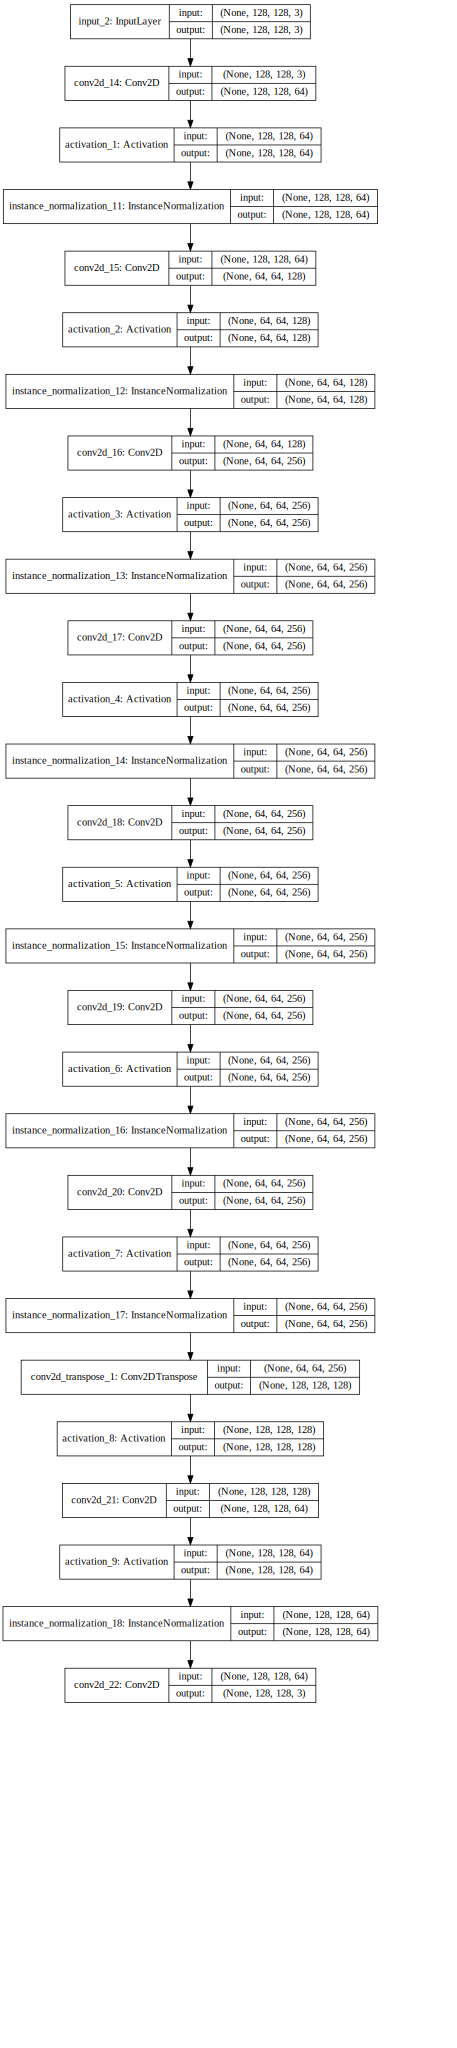

In [11]:
generator = build_generator()
generator.compile(loss = 'mse', optimizer = optimizers.Adam(lr=0.0001, beta_1=0.5))
generator.summary()

# # Saving the Summary and Architecture
# with open('./drive/My Drive/Colab Notebooks/aml_proj3/inception_resnetv2/model/generator_summary.txt', 'w') as f:
#     with redirect_stdout(f):
#         generator.summary()
# plot_model(generator, to_file='./drive/My Drive/Colab Notebooks/aml_proj3/inception_resnetv2/model/generator_model.png')
SVG(model_to_dot(generator, show_layer_names=True, show_shapes=True, dpi=60).create(prog='dot', format='svg'))

## GAN

In [0]:
def build_gan():
    discriminator.trainable = False

    gan_input = Input(shape=(IMAGE_SZ, IMAGE_SZ, 3))      ## These are masked or Padded Images of shape 128x128 but the 0 to 32 and 96 to 128 will be masked
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    
    gan = Model(gan_input,[generated_image, gan_output])
    return gan

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
model_2 (Model)              (None, 128, 128, 3)       3334163   
_________________________________________________________________
model_1 (Model)              (None, 1)                 3502869   
Total params: 6,837,032
Trainable params: 3,334,163
Non-trainable params: 3,502,869
_________________________________________________________________


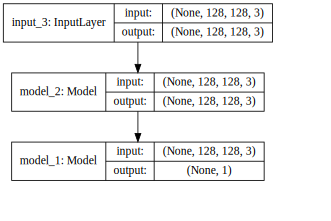

In [13]:
gan = build_gan()
alpha=0.0004
gan.compile(loss = [losses.MSE, losses.MSE], optimizer = optimizers.Adam(lr=0.0001, beta_1=0.5), loss_weights = [1, alpha])
gan.summary()

SVG(model_to_dot(gan, show_layer_names=True, show_shapes=True, dpi=60).create(prog='dot', format='svg'))

# Masking and Unmasking

In [0]:
padding_width = int(IMAGE_SZ / 4)

def get_masked_images(imgs, padding_width):
    padded_imgs = np.copy(imgs)
    pix_avg = np.mean(padded_imgs, axis=(1, 2, 3))
    padded_imgs[:, :, :padding_width, :] = padded_imgs[:, :, -padding_width:, :] = pix_avg.reshape(-1, 1, 1, 1) #calculating mean pixel intensity and place it masked pixels
    return padded_imgs

def crop_and_resize_image(img, img_size):
    source_size = img.size
    if source_size == img_size:
        return img
    img = img.resize(img_size)
    return img
    
def renorm_image(img_norm):
    img_renorm = (img_norm * 255).astype(np.uint8)
    return img_renorm

In [0]:
class DataGenerator(object):
    def __init__(self, root_dir, img_size= (128, 128), batch_size=32, padding_width= 32, validation_rate=0.1):
        self.batch_size = batch_size
        self.img_size = img_size
        self.padding_width = padding_width

        self.reset()
        self.img_file_list = [] # all the images

        for root, dirs, files in os.walk(root_dir):
            for f in files:
                full_path = os.path.join(root, f)
                if imghdr.what(full_path) is None:
                    continue
                self.img_file_list.append(full_path)
        
        validation_size = math.floor(validation_rate*len(self.img_file_list)) #validation dataset size
        self.validation_file_list = self.img_file_list[:validation_size] #### shouldn't this be reverse???
        self.img_file_list = self.img_file_list[validation_size: ]

    def __len__(self):
        return len(self.img_file_list)

    def reset(self):
        self.images = []
        self.points = []
        self.masks = []

    def get_file_generator(self, file_list, shuffle=True):
        while True:
            if shuffle:
                np.random.shuffle(file_list)
            for f in file_list:
                img = crop_and_resize_image(load_img(f), self.img_size) # loading an image and resize
                self.images.append(img_to_array(img))

                if len(self.images) == self.batch_size: # creating a batch
                    imgs = (np.asarray(self.images, dtype=np.float32) / 255.0) * 2 - 1 # Normalizing the Images for an entire batch
                    self.reset()
                    yield get_masked_images(imgs, self.padding_width), imgs # returns both masked and actual images

    def flow(self):
        return self.get_file_generator(self.img_file_list) 

    def validation_flow(self, validation_steps=1):
        return self.get_file_generator(self.validation_file_list, shuffle=False)

In [0]:
def plot_history(loss_history, model_name):
    plt.plot(loss_history['loss'])
    plt.plot(loss_history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # summarize history for loss plt.plot(history.history['loss']) plt.plot(history.history['val_loss']) plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.savefig('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/log/{}'.format(model_name)) #, transparent=True
    plt.close()

In [0]:
def plot_generated_image(generator, data_generator):
    masked_images, images = next(data_generator.validation_flow()) # change this later to Train and Val.. validation flow must be train
    generated_images = generator.predict(masked_images)
    plt.figure(figsize=(3, 6))
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    for i in range(5):
        plt.subplot(5, 2, 2* i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow((generated_images[i] + 1) / 2)
        plt.subplot(5, 2, 2* i + 2)
        plt.xticks([])
        plt.yticks([])
        plt.imshow((images[i] + 1) / 2)
    plt.savefig('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/log/{}'.format('test')) #, transparent=True
    plt.close()

In [0]:
def get_counter():
    counter = 0

    def inner_func():
        nonlocal counter
        counter += 1
        if counter == 20:
            counter = 0
            return True
        return False
    return inner_func

def printmd(string):
    display(Markdown(string))

In [0]:
def image_and_label(generator, masked_images, real_images, batch_size):
    generated_images = generator.predict(masked_images)
    combined_images = np.concatenate([generated_images, real_images])
    labels = np.concatenate([np.zeros((batch_size, 1), dtype='float32'), np.ones((batch_size, 1), dtype='float32')])
    return combined_images, labels

def train(path, batch_size = 32, epochs = 1000, steps_per_epoch=None):
    input_shape = (128, 128, 3)
    padding_width = 32
    is_log = get_counter()

    data_generator = DataGenerator(path, img_size=(128, 128), batch_size=32, padding_width=padding_width)
    data_size = len(data_generator)
    print('data size: {}'.format(data_size))

    if steps_per_epoch is None:
        steps_per_epoch = data_size // batch_size

    t1_epochs = epochs * 18 // 100
    t2_epcohs = epochs * 2 // 100
    t3_epochs = epochs * 80 // 100


    generator_history = {'loss': [], 'val_loss': []}
    discriminator_history = {'loss': [], 'val_loss': []}
    gan_history = {'loss': [], 'val_loss': []}

    class LogCallback(keras.callbacks.Callback):
        def on_batch_end(self, batch, logs=None):
            if is_log():
                generator_history['loss'].append(logs['loss'])
                masked_images, real_images = next(data_generator.validation_flow())
                val_loss = generator.evaluate(masked_images, real_images, batch_size)
                generator_history['val_loss'].append(val_loss)
                plot_history(generator_history, 'Generator')
                plot_generated_image(generator, data_generator)
    
    printmd('Phase 1 - Updating the Generator')
    if os.path.exists('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/checkpoint/generator.h5'):
        generator.load_weights('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/checkpoint/generator.h5')
        generator_history = json.load(open('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/checkpoint/generator_history.json', 'r', encoding='utf-8'))
        print('Get Trained Generator Weight')
    else:
        logcallback_object = LogCallback()
        generator_loss = generator.fit_generator(data_generator.flow(), epochs=t1_epochs, steps_per_epoch=steps_per_epoch, validation_data=data_generator.validation_flow(), validation_steps=2, callbacks=[logcallback_object])
        generator.save_weights('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/checkpoint/generator.h5') 
        generator_history = generator_loss.history   
        json.dump(generator_history, open('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/checkpoint/generator_history.json', 'w', encoding='utf-8'))
    
    json.dump(gan_history, open('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/checkpoint/gan_history.json', 'w', encoding='utf-8'))
    json.dump(discriminator_history, open('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/checkpoint/discriminator_history.json', 'w', encoding='utf-8'))
    json.dump(generator_history, open('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/checkpoint/generator_end_history.json', 'w', encoding='utf-8'))

    gan.save_weights('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/checkpoint/gan.h5')
    discriminator.save_weights('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/checkpoint/discriminator.h5')
    generator.save_weights('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/checkpoint/generator_end.h5')

    print('Phase 2 - Updating the Discriminator')
    counter = 0
    for current_epoch in range(t2_epcohs):
        print('Epoch {}/{}'.format(current_epoch, t2_epcohs))
        progressbar = generic_utils.Progbar(steps_per_epoch)
        for data in itertools.islice(data_generator.flow(), None, steps_per_epoch):
            masked_images, real_images = data
            fake_images = generator.predict(masked_images)
            disc_loss_real = discriminator.train_on_batch(real_images, np.ones(batch_size, dtype='float32'))
            disc_loss_fake = discriminator.train_on_batch(fake_images, np.zeros(batch_size, dtype='float32'))

            disc_loss = (disc_loss_real + disc_loss_fake)/2

            progressbar.add(1, values = [('Discriminator Loss', disc_loss)])
            if is_log():
                discriminator_history['loss'].append(float(disc_loss))
                masked_images, real_images = next(data_generator.validation_flow())
                combined_images, labels = image_and_label(generator, masked_images, real_images, batch_size)
                disc_val_loss = discriminator.evaluate(combined_images, labels)
                discriminator_history['val_loss'].append(float(disc_val_loss))
                plot_history(discriminator_history, 'Discriminator')

    print('Phase 3 - Training the Generator and Discriminator Adversarially')
    for current_epoch in range(t3_epochs):
        print('Epoch {}/{}'.format(current_epoch, t3_epochs))
        progressbar = generic_utils.Progbar(steps_per_epoch)
        for data in itertools.islice(data_generator.flow(), None, steps_per_epoch):
            masked_images, real_images = data
            fake_images = generator.predict(masked_images)
            disc_loss_real = discriminator.train_on_batch(real_images, np.ones(batch_size, dtype='float32'))
            disc_loss_fake = discriminator.train_on_batch(fake_images, np.zeros(batch_size, dtype='float32'))

            disc_loss = (disc_loss_real + disc_loss_fake)/2

            gan_loss = gan.train_on_batch(masked_images, [real_images, np.ones((batch_size, 1), dtype='float32')])

            progressbar.add(1, values = [('Discriminator Loss', disc_loss), ('GAN Loss', gan_loss[0]), ('Generator Loss', gan_loss[1])])

            if is_log():
                discriminator_history['loss'].append(float(disc_loss))
                gan_history['loss'].append(float(gan_loss[0]))
                generator_history['loss'].append(float(gan_loss[1]))
                masked_iamges, real_images = next(data_generator.validation_flow())
                gan_loss = gan.evaluate(masked_iamges, [real_images, np.ones((batch_size, 1), dtype='float32')])
                combined_images, labels = image_and_label(generator, masked_iamges, real_images, batch_size)
                disc_loss = discriminator.evaluate(combined_images, labels)
                discriminator_history['val_loss'].append(float(disc_loss))
                gan_history['val_loss'].append(float(gan_loss[0]))
                generator_history['val_loss'].append(float(gan_loss[1]))
                plot_history(discriminator_history, 'Discriminator')
                plot_history(gan_history, 'GAN')
                plot_history(generator_history, 'Generator')
                plot_generated_image(generator, data_generator)
    
    generator.save_weights('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/checkpoint/generator_end.h5')
    json.dump(generator_history, open('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/checkpoint/generator_end_history.json', 'w', encoding='utf-8'))
    discriminator.save_weights('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/checkpoint/discriminator.h5')
    json.dump(discriminator_history, open('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/checkpoint/discriminator_history.json', 'w', encoding='utf-8'))

In [0]:
train('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/data/train_data/')

In [0]:
def overfit_a_img(path):
    img = PIL.Image.open('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/test/bea4.jpg')

    img = (np.array([img_to_array(crop_and_resize_image(img, (128, 128)))])/255.0) * 2-1
    padded_img = get_masked_images(img, 32)

    array_to_img(img[0]).save('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/test/aa1.jpg')
    array_to_img(padded_img[0]).save('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/test/pad1.jpg')

    generator.load_weights('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/checkpoint/generator_end.h5')
    generator.fit(padded_img, img, epochs=10, steps_per_epoch=100)
    a = generator.predict(padded_img)
    array_to_img((a[0] + 1) / 2).save('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/test/444.jpg')

In [22]:
overfit_a_img('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/test/bea4.jpg')









Epoch 1/10
100/100 [==============================] - 110s 1s/step - loss: 0.1679
Epoch 2/10
100/100 [==============================] - 108s 1s/step - loss: 0.1543
Epoch 3/10
100/100 [==============================] - 108s 1s/step - loss: 0.1525
Epoch 4/10
100/100 [==============================] - 108s 1s/step - loss: 0.1515
Epoch 5/10
100/100 [==============================] - 108s 1s/step - loss: 0.1509
Epoch 6/10
100/100 [==============================] - 108s 1s/step - loss: 0.1505
Epoch 7/10
100/100 [==============================] - 108s 1s/step - loss: 0.1502
Epoch 8/10
100/100 [==============================] - 106s 1s/step - loss: 0.1500
Epoch 9/10
100/100 [==============================] - 106s 1s/step - loss: 0.1498
Epoch 10/10
100/100 [==============================] - 107s 1s/step - loss: 0.1497


In [0]:
# Computing the RMSE between a ground truth and outpainted image
def compute_RMSE(image_gt_PATH, image_op_PATH):
    image_gt = PIL.Image.open(image_gt_PATH).convert('RGB')
    image_gt = np.array(crop_and_resize_image(image_gt, (128, 128)))
    image_op = np.array(PIL.Image.open(image_op_PATH).convert('RGB')).astype(np.float64)
    assert image_gt.shape == (128, 128, 3)
    assert image_op.shape == (128, 128, 3)
    M = np.ones((128, 128, 3))
    M[:, 32:96:, :] = 0
    num_pixels = 128 * 64 * 3
    return np.sqrt(np.sum(((image_gt - image_op) * M) ** 2) / num_pixels)

In [24]:
compute_RMSE('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/test/bea4.jpg', '/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/test/444.jpg')

51.88916567379858

In [0]:
def generate_all_val():
    data_generator = DataGenerator('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/data/val_data', (128, 128), 10, 32)
    data_size = len(data_generator)

    print(len(data_generator.validation_file_list),
          len(data_generator.img_file_list))

    generator.load_weights('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/checkpoint/generator_end.h5')

    for ii, val in enumerate(data_generator.validation_flow()):
        a = generator.predict(val[0])

        for i, img in enumerate(zip(val[1], a)):
            array_to_img((img[0] + 1) /
                         2).save('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/output\{}-{}.jpg'.format(ii, i))
            array_to_img(
                img[1] + 1 / 2).save('/content/drive/My Drive/Colab Notebooks/CSE676: Deep Learning/Project 2/output\{}-{}_gen.jpg'.format(ii, i))


In [0]:
generate_all_val()